In [1]:
import scanit
import scanpy as sc
import pandas as pd
import anndata
import numpy as np
import SpatialDE
from scipy import sparse
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering, KMeans
import matplotlib.pyplot as plt
import stlearn as st
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import normalized_mutual_info_score

In [3]:
adata10 = sc.read_h5ad('/Users/oliviaguo/Documents/Undergraduate/Year2/M2R_Graph-based_Clustering/151510.h5ad')

# Preprocessing
adata10_sp = adata10.copy()
sc.pp.normalize_total(adata10_sp)
gene = adata10_sp.X.toarray()
gene_df = pd.DataFrame(gene, index=adata10_sp.obs_names, columns=adata10_sp.var_names)
pts = adata10_sp.obsm["spatial"]
pts_df = pd.DataFrame(pts, index=adata10_sp.obs_names, columns=["x", "y"])
gene_df.index.name, pts_df.index.name = "index", "index"
results = SpatialDE.run(pts_df, gene_df)
svg_genes = results[results['qval'] < 0.05]
sc.pp.log1p(adata10_sp)

Models: 100%|██████████| 10/10 [1:07:59<00:00, 408.00s/it]


In [4]:
n_sv_genes = 50
top_sv_genes = svg_genes.sort_values("qval").head(n_sv_genes)
svg = list(top_sv_genes["g"])
adata10_sp = adata10[:, svg]

In [5]:
adata10_sp = adata10_sp.copy()
adata10_sp.X = adata10_sp.X.toarray()
print(adata10_sp.shape)
print(type(adata10_sp.X))

(4634, 50)
<class 'numpy.ndarray'>


In [36]:
scanit.tl.spatial_graph(adata10_sp, method='alpha shape', alpha_n_layer=1, knn_n_neighbors=5)
scanit.tl.spatial_representation(adata10_sp, n_h=10, n_epoch=3000, lr=0.001, device='mps', n_consensus=2, projection='mds', 
    python_seed=0, torch_seed=0, numpy_seed=0)

Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 2000, Loss: 0.4138
Epoch: 2500, Loss: 0.4543
Epoch: 2999, Loss: 0.4172
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4084
Epoch: 2000, Loss: 0.4101
Epoch: 2500, Loss: 0.3624
Epoch: 2999, Loss: 0.3778


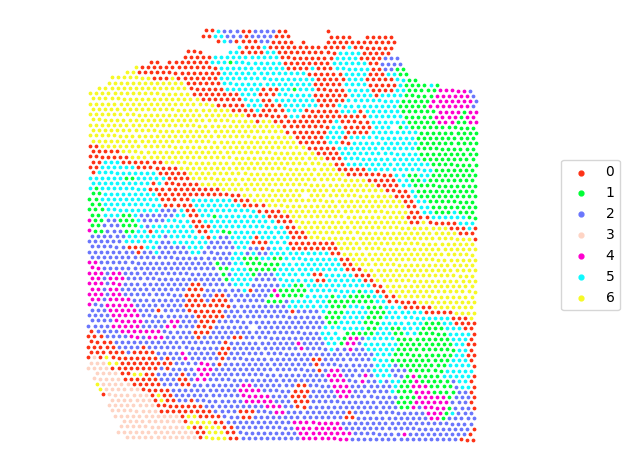

In [ ]:
X_scanit = adata10_sp.obsm['X_scanit']
kmeans = KMeans(n_clusters=7, random_state=0, n_init='auto')
labels_pred = kmeans.fit_predict(X_scanit)
adata10_sp.obs['kmeans'] = labels_pred.astype(str)
pts = adata10_sp.obsm['spatial']
color_list = plotly.colors.qualitative.Light24
labels_pred = np.array(adata10_sp.obs['kmeans'], int)
labels = list(set(labels_pred))
labels = list(np.sort(labels))
for j in range(len(labels)):
    label = labels[j]
    idx = np.where(labels_pred == label)[0]
    plt.scatter(pts[idx, 0], pts[idx, 1], c=color_list[j], label=str(label), s=3)

plt.axis('equal')
plt.axis('off')
plt.legend(markerscale=2, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("151510_spatial_kmeans.png", dpi=300, bbox_inches='tight')


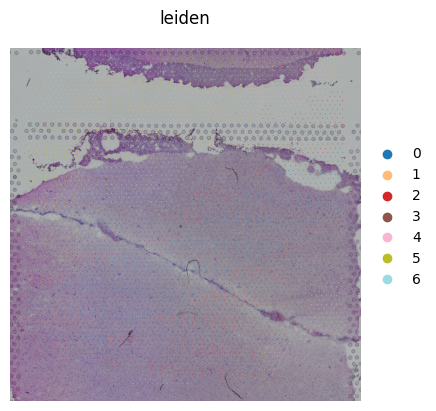

<Figure size 640x480 with 0 Axes>

In [44]:
sc.pp.neighbors(adata10_sp, use_rep='X_scanit', n_neighbors=10)
# finds clusters within that graph using Leiden clustering algorithm.
sc.tl.leiden(adata10_sp, resolution=0.2)
sc.pl.spatial(adata10_sp, spot_size=20, color='leiden', frameon=False, palette='tab20')
plt.savefig("151510_leiden.png", dpi=300, bbox_inches='tight')

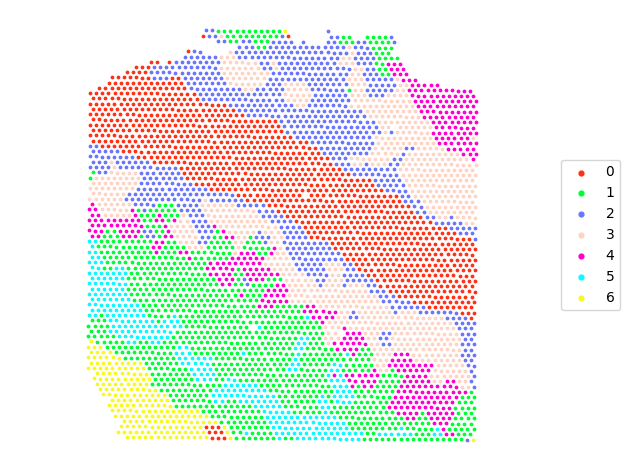

In [45]:
import plotly
pts = adata10_sp.obsm['spatial']
color_list = plotly.colors.qualitative.Light24
labels_pred = np.array( adata10_sp.obs['leiden'], int )
labels = list(set(labels_pred))
labels = list(np.sort(labels))
for j in range(len(labels)):
    label = labels[j]
    idx = np.where(labels_pred == label)[0]
    plt.scatter(pts[idx,0], pts[idx,1], c=color_list[j], label = label, s=3)
plt.axis('equal')
plt.axis('off')
plt.legend(markerscale=2, loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.savefig("151510_spatial.png", dpi=300, bbox_inches='tight')

In [104]:
encoder = LabelEncoder()
flat_arr = np.array(adata10_sp.obs['sce.layer_guess']).ravel()
encoder.fit(flat_arr)
label_true = encoder.transform(flat_arr)
sc.pp.neighbors(adata10_sp, use_rep='X_scanit', n_neighbors=10)
sc.tl.leiden(adata10_sp, resolution=0.2)
normalized_mutual_info_score(label_true, adata10_sp.obs['leiden'])


0.5141185327308809

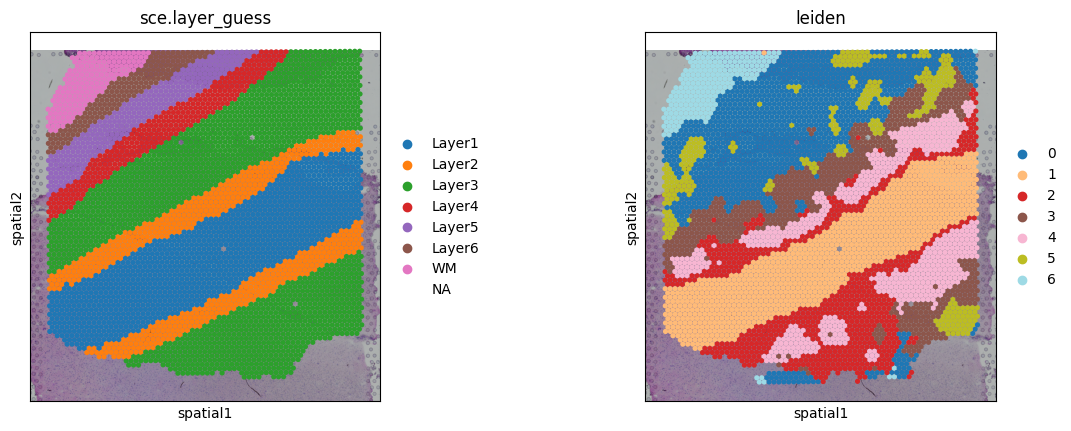

In [107]:
sc.pl.spatial(adata10_sp, color=['sce.layer_guess', 'leiden'], size=1.5)

In [75]:
normalized_mutual_info_score(label_true, adata10_sp.obs['leiden'])

0.524779668625102

In [22]:
X_scanit = adata10_sp.obsm['X_scanit']
kmeans = KMeans().fit(X_scanit)

In [76]:
normalized_mutual_info_score(label_true, adata10_sp.obs['leiden_umap'])

0.522902670048731

In [77]:
print(adata10_sp.obsp.keys())

KeysView(PairwiseArrays with keys: spatial_connectivities, spatial_distances, scanit-graph, D_scanit, distances, connectivities)


In [78]:
print(type(adata10_sp.obsp['scanit-graph']))
print(adata10_sp.obsp['scanit-graph'].shape)

print(type(adata10_sp.obsp['spatial_connectivities']))
print(adata10_sp.obsp['spatial_connectivities'].shape)

<class 'scipy.sparse._csr.csr_array'>
(4634, 4634)
<class 'scipy.sparse._csr.csr_matrix'>
(4634, 4634)


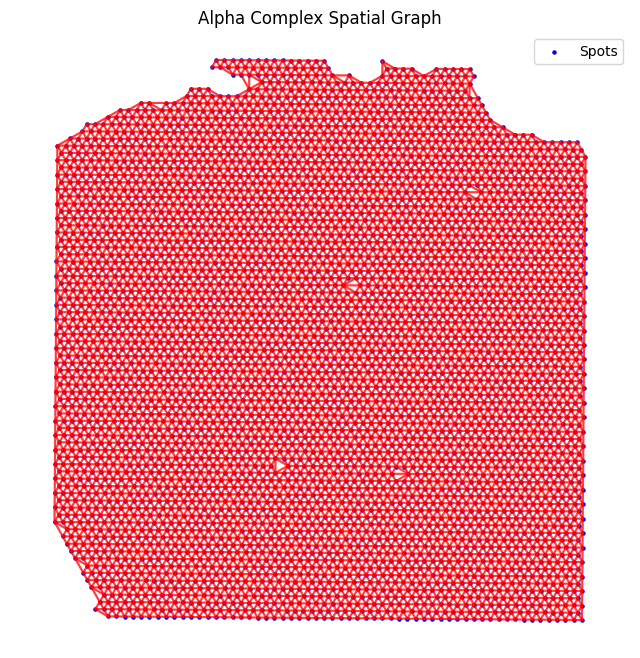

<Figure size 640x480 with 0 Axes>

In [100]:
edges = adata10_sp.obsp['scanit-graph']

row, col = edges.nonzero()

plt.figure(figsize=(8,8))
plt.scatter(pts[:,0], pts[:,1], c='blue', s=5, label='Spots')

for i, j in zip(row, col):
    x = [pts[i,0], pts[j,0]]
    y = [pts[i,1], pts[j,1]]
    plt.plot(x, y, color='red', alpha=0.5)

plt.title('Alpha Complex Spatial Graph')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()
plt.savefig("alpha_complex_10.png", dpi=300, bbox_inches='tight')


In [ ]:
encoder = LabelEncoder()
flat_arr = np.array(adata10_sp.obs['sce.layer_guess']).ravel()
encoder.fit(flat_arr)
label_true = encoder.transform(flat_arr)

for i in range(10):
    scanit.tl.spatial_representation(
        adata10_sp,
        n_h=10,
        n_epoch=2000,
        lr=0.001,
        device='mps',
        n_consensus=2,
        projection='mds',
        python_seed=i,
        torch_seed=i,
        numpy_seed=i,
        n_comps_proj = 10
    )

    sc.pp.neighbors(adata10_sp, use_rep='X_scanit', n_neighbors=10)
    sc.tl.leiden(adata10_sp, resolution=0.2)

    label_pred = np.array(adata10_sp.obs['leiden'], dtype=int)
    nmi = normalized_mutual_info_score(label_true, label_pred)
    nmis.append(nmi)

Epoch: 000, Loss: 1.3833
Epoch: 500, Loss: 0.4598
Epoch: 1000, Loss: 0.4600
Epoch: 1500, Loss: 0.4330
Epoch: 1999, Loss: 0.4228
Epoch: 000, Loss: 1.4780
Epoch: 500, Loss: 0.5395
Epoch: 1000, Loss: 0.5222
Epoch: 1500, Loss: 0.4408
Epoch: 1999, Loss: 0.4164


Python(1350) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pk

Epoch: 000, Loss: 1.4159
Epoch: 500, Loss: 0.4527
Epoch: 1000, Loss: 0.3594
Epoch: 1500, Loss: 0.3339
Epoch: 1999, Loss: 0.3228
Epoch: 000, Loss: 2.2644
Epoch: 500, Loss: 0.5702
Epoch: 1000, Loss: 0.4361
Epoch: 1500, Loss: 0.4020
Epoch: 1999, Loss: 0.4202


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.3988
Epoch: 500, Loss: 0.4681
Epoch: 1000, Loss: 0.4092
Epoch: 1500, Loss: 0.3690
Epoch: 1999, Loss: 0.3181
Epoch: 000, Loss: 1.4338
Epoch: 500, Loss: 0.5383
Epoch: 1000, Loss: 0.4509
Epoch: 1500, Loss: 0.4265
Epoch: 1999, Loss: 0.3754


Python(1419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 000, Loss: 1.3976
Epoch: 500, Loss: 0.4896
Epoch: 1000, Loss: 0.4110
Epoch: 1500, Loss: 0.4357
Epoch: 1999, Loss: 0.4003
Epoch: 000, Loss: 1.3974
Epoch: 500, Loss: 0.4456
Epoch: 1000, Loss: 0.3574
Epoch: 1500, Loss: 0.3160
Epoch: 1999, Loss: 0.3221


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See h

Epoch: 000, Loss: 2.1606
Epoch: 500, Loss: 0.6647
Epoch: 1000, Loss: 0.4090
Epoch: 1500, Loss: 0.3713
Epoch: 1999, Loss: 0.3431
Epoch: 000, Loss: 1.9811
Epoch: 500, Loss: 0.5811
Epoch: 1000, Loss: 0.4615
Epoch: 1500, Loss: 0.4167
Epoch: 1999, Loss: 0.4035


Python(1761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(1764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


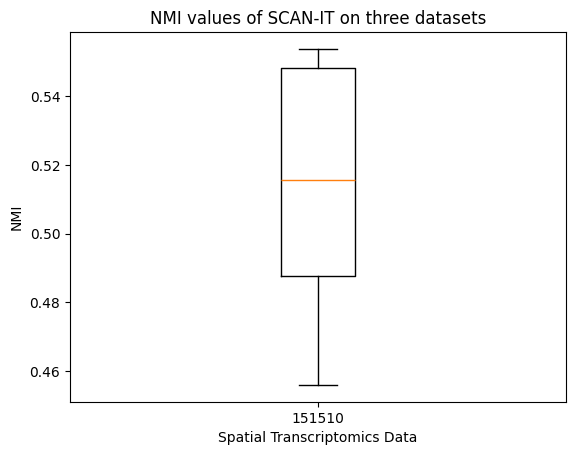

In [99]:
plt.boxplot(nmis, labels=['151510'])
plt.title('NMI values of SCAN-IT on three datasets')
plt.ylabel('NMI')
plt.xlabel('Spatial Transcriptomics Data')
plt.savefig("nmi.png", dpi=300, bbox_inches='tight')

In [82]:
encoder = LabelEncoder()

flat_arr = np.array([adata10_sp.obs['sce.layer_guess']]).ravel()
encoder.fit(flat_arr)

label_true = encoder.transform(flat_arr)

In [83]:
labels_kmeans = np.array(adata10_sp.obs['kmeans'], int)

In [ ]:
normalized_mutual_info_score(label_true, adata10_sp.obs['leiden'])

0.522902670048731

In [26]:
scanit.tl.spatial_graph(adata10_sp, method='alpha shape', alpha_n_layer=1, knn_n_neighbors=5)
scanit.tl.spatial_representation(adata10_sp, n_h=10, n_epoch=2000, lr=0.001, device='mps', n_consensus=2, projection='mds', 
python_seed=0, torch_seed=0, numpy_seed=0, n_comps_proj = 5)

Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4989
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4108


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See h

In [27]:
adata10_sp.obsm["X_scanit"].shape

(4634, 5)

In [29]:
array = np.zeros(20)
for i in range(1, 21):
    scanit.tl.spatial_graph(adata10_sp, method='alpha shape', alpha_n_layer=1, knn_n_neighbors=5)
    scanit.tl.spatial_representation(adata10_sp, n_h=10, n_epoch=2000, lr=0.001, device='mps', n_consensus=2, projection='mds', 
    python_seed=0, torch_seed=0, numpy_seed=0, n_comps_proj = i)
    X_scanit = adata10_sp.obsm['X_scanit']
    kmeans = KMeans().fit(X_scanit)
    encoder = LabelEncoder()
    flat_arr = np.array([adata10_sp.obs['sce.layer_guess']]).ravel()
    encoder.fit(flat_arr)
    label_true = encoder.transform(flat_arr)
    array[i-1] = normalized_mutual_info_score(label_true, kmeans.labels_)
array

Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5078
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See h

Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4362
Epoch: 1500, Loss: 0.4082
Epoch: 1999, Loss: 0.4109
Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4079
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4084
Epoch: 1999, Loss: 0.4109


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4084
Epoch: 1999, Loss: 0.4109
Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4362
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4110


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5078
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4362
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4110
Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5078
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4360
Epoch: 1500, Loss: 0.4082
Epoch: 1999, Loss: 0.4110


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4108
Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5078
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4082
Epoch: 1999, Loss: 0.4108


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4108


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4362
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109
Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4364
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5087
Epoch: 1000, Loss: 0.4787
Epoch: 1500, Loss: 0.4486
Epoch: 1999, Loss: 0.4052
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4366
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109
Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4365
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See h

Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5087
Epoch: 1000, Loss: 0.4788
Epoch: 1500, Loss: 0.4486
Epoch: 1999, Loss: 0.4052
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4365
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109
Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5078
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4361
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5079
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4362
Epoch: 1500, Loss: 0.4082
Epoch: 1999, Loss: 0.4109
Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5077
Epoch: 1000, Loss: 0.4790
Epoch: 1500, Loss: 0.4532
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4367
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Epoch: 000, Loss: 1.4691
Epoch: 500, Loss: 0.5078
Epoch: 1000, Loss: 0.4789
Epoch: 1500, Loss: 0.4531
Epoch: 1999, Loss: 0.4078
Epoch: 000, Loss: 1.6159
Epoch: 500, Loss: 0.4988
Epoch: 1000, Loss: 0.4366
Epoch: 1500, Loss: 0.4083
Epoch: 1999, Loss: 0.4109


array([0.25793675, 0.39086152, 0.41969418, 0.44909954, 0.45678573,
       0.45396125, 0.44353068, 0.44282702, 0.45597952, 0.46407967,
       0.45777279, 0.44947821, 0.46477263, 0.4455576 , 0.44125179,
       0.4313112 , 0.44315706, 0.4376448 , 0.45283712, 0.44331687])

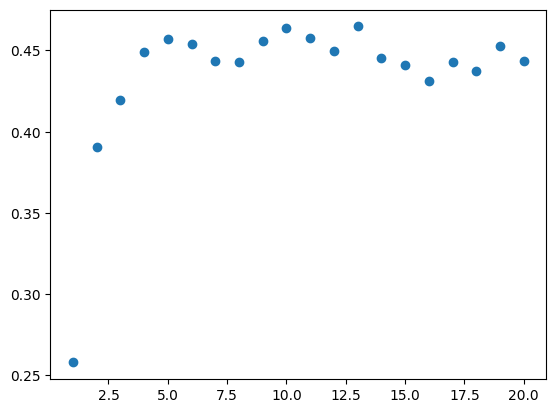

In [30]:
plt.scatter(np.arange(1, 21), array)